# Pangenome SRA exploration

## Setup

In [1]:
## Notebook config

import sys
if '../' not in sys.path:
    sys.path.append("../")
%load_ext dotenv
%reload_ext dotenv
%dotenv

In [2]:
# Notebook imports

import ast
import os
import pickle
import collections
import csv
from IPython.display import display

from graphdatascience import GraphDataScience
import psycopg2
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv
import pandas as pd
import seaborn as sns
import torch
from Bio import Entrez, SeqIO

/home/rnalab/ljp/.conda/envs/ljp/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
DATASET_DIR = './dataset/'
EVALS_DIR = './evals/'
PROJECTION_NAME_PREFIX = 'sra_projection_'
RANDOM_SEED = 42

In [4]:
def get_public_serratus_connection():
    # These credentials are public:
    # https://github.com/ababaian/serratus/wiki/SQL-Schema
    return psycopg2.connect(
        database="summary",
        host="serratus-aurora-20210406.cluster-ro-ccz9y6yshbls.us-east-1.rds.amazonaws.com",
        user="public_reader",
        password="serratus",
        port="5432")

psql_client = get_public_serratus_connection()
print(psql_client)

<connection object at 0x7f9b7ff4de00; dsn: 'user=public_reader password=xxx dbname=summary host=serratus-aurora-20210406.cluster-ro-ccz9y6yshbls.us-east-1.rds.amazonaws.com port=5432', closed: 0>


In [5]:
def get_knowledge_graph_connection():
    return GraphDataScience(
        os.environ.get('NEO4J_KG_URI'),
        auth=(
            os.environ.get('NEO4J_KG_USER'), 
            os.environ.get('NEO4J_KG_PASSWORD'),
        )
    )
kg_client = get_knowledge_graph_connection()
print(kg_client)

ValueError: Invalid endpoint type: <class 'NoneType'>

In [6]:
def get_pangenome_graph_connection():
    return GraphDataScience(
        os.environ.get('NEO4J_URI'),
        auth=(
            os.environ.get('NEO4J_USER'), 
            os.environ.get('NEO4J_PASSWORD'),
        )
    )
pg_client = get_pangenome_graph_connection()
print(pg_client)

## SRA metadata investigation

In [7]:
# NCBI API helpers

Entrez.email = "rnabased.lifeforms@gmail.com"
try:
    with open(DATASET_DIR + 'gb_cache.pkl', 'rb') as f:
        gb_cache = pickle.load(f)
except:
    gb_cache = {}

def get_gb_record(accession):
    if accession in gb_cache:
        return gb_cache[accession]
    handle = Entrez.efetch(db="nucleotide", id=accession, rettype="gb", retmode="text")
    record = SeqIO.read(handle, "genbank")
    gb_cache[accession] = record
    return record

def get_tax_id(record):
    for feature in record.features:
        if feature.type == 'source':
            return feature.qualifiers["db_xref"][0].strip('taxon:')

    species = record.annotations['organism'].strip()
    species = species.replace('_', '+')
    species = species.replace('(', '')
    species = species.replace(')', '')
    search = Entrez.esearch(term=species, db='taxonomy', retmode='xml')
    record = Entrez.read(search)
    return record['IdList'][0]

def get_host(record):
    for feature in record.features:
        if feature.type == 'source':
            return feature.qualifiers["host"][0]
    return None

def get_host_tax_id(record):
    for feature in record.features:
        if feature.type == 'source':
            tax_str = feature.qualifiers["db_xref"][0]
            return tax_str.split(':')[1]
    return None

In [8]:
nodes = pd.read_csv(DATASET_DIR + 'pangenome_nodes.csv')

# get unique genome accessions
genbank_acc = nodes.loc[
    nodes['nodeLabels'] == 'Fasta',
    'accession'
].unique()

print(len(genbank_acc))

6674


In [9]:
def get_genbank_taxids(genbank_acc):
    if os.path.exists(DATASET_DIR + 'gb_tax_id.csv'):
        return pd.read_csv(DATASET_DIR + 'gb_tax_id.csv')
    else:
        genbank_taxids_dict = collections.defaultdict(list)
        missing = []
        for acc in genbank_acc:
            try:
                record = get_gb_record(acc)
                tax_id = get_tax_id(record)
                genbank_taxids_dict[tax_id].append(acc)
            except:
                print(f'Error fetching {acc}')
                missing.append(acc)
        
        # convert genbank_taxids to df
        rows = []
        for tax_id, accs in genbank_taxids_dict.items():
            for acc in accs:
                rows.append((tax_id, acc))
        genbank_taxids_df = pd.DataFrame(rows, columns=['tax_id', 'accession'])
        genbank_taxids_df.to_csv(DATASET_DIR + 'gb_tax_id.csv', index=False)

        # with open('./gb_cache.pkl', 'wb') as f:
        #     pickle.dump(gb_cache, f)
            
        return genbank_taxids_df

genbank_taxids = get_genbank_taxids(genbank_acc)

In [9]:
def get_genbank_host(genbank_acc):
    genbank_host_dict = collections.defaultdict(list)
    missing = []
    for acc in genbank_acc:
        try:
            record = get_gb_record(acc)
            host = get_host(record)
            genbank_host_dict[host].append(acc)
        except:
            missing.append(acc)
    
    # convert genbank_host to df
    rows = []
    for host, accs in genbank_host_dict.items():
        for acc in accs:
            rows.append((host, acc))
    genbank_host_df = pd.DataFrame(rows, columns=['host', 'accession'])
    # genbank_host_df.to_csv(DATASET_DIR + 'gb_host.csv', index=False)
    print(len(missing))
    return genbank_host_df


genbank_host = get_genbank_host(genbank_acc)
print(len(genbank_host))

In [ ]:
def get_genbank_complete_genomes(genbank_acc):
    genbank_complete_genomes = []
    for acc in genbank_acc:
        try:
            record = get_gb_record(acc)
            if 'complete' in record.description:
                genbank_complete_genomes.append(acc)
        except:
            print(f'Error fetching {acc}')
    return genbank_complete_genomes

genbank_complete_genomes = get_genbank_complete_genomes(genbank_acc)
print(len(genbank_complete_genomes))

4839


In [ ]:
query = f"""
SELECT
    palm_id, gb_acc, percent_identity, pp_cov, evalue, tax_id
FROM
    public.palm_gb
WHERE
    gb_acc IN 
    (
        {', '.join([f"'{acc}.1'" for acc in genbank_acc])}
    )
"""

palm_gb = pd.read_sql_query(query, psql_client)
palm_gb.head()

/tmp/ipykernel_11141/402326601.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  palm_gb = pd.read_sql_query(query, psql_client)


,palm_id,gb_acc,percent_identity,pp_cov,evalue,tax_id


In [10]:
def get_palm_gb():
    if os.path.exists(DATASET_DIR + 'palm_gb.csv'):
        return pd.read_csv(DATASET_DIR + 'palm_gb.csv')
    else:
        query = f"""
        SELECT
            palm_id, gb_acc, percent_identity, pp_cov, evalue, tax_id
        FROM
            public.palm_gb
        WHERE
            tax_id IN 
            (
                {', '.join([f"'{tax_id}'" for tax_id in genbank_taxids['tax_id'].unique()])}
            )
        """
        palm_gb = pd.read_sql_query(query, psql_client)
        palm_gb.head()
        palm_gb.to_csv(DATASET_DIR + 'palm_gb.csv', index=False)
        return palm_gb

palm_gb = get_palm_gb()
print(palm_gb.shape)

(88144, 6)


In [11]:
def get_palm_sotu(palm_gb):
    if os.path.exists(DATASET_DIR + 'palm_sotu.csv'):
        return pd.read_csv(DATASET_DIR + 'palm_sotu.csv')
    else:
        signficant_palm_gb = palm_gb.loc[
            palm_gb['percent_identity'] > 90
        ]
        print(signficant_palm_gb.shape)

        query = f"""
        SELECT palm_id, sotu, percent_identity
        FROM public.palmdb2
        WHERE palm_id IN (
            {', '.join([f"'{palm_id}'"  for palm_id in signficant_palm_gb['palm_id']])}
        )
        """
        palm_sotu = pd.read_sql_query(query, psql_client)
        palm_sotu.to_csv(DATASET_DIR + 'palm_sotu.csv', index=False)
        return palm_sotu


palm_sotu = get_palm_sotu(palm_gb)
print(palm_sotu.shape)
print(palm_sotu['sotu'].nunique())

(34107, 3)
3663


In [12]:
def get_sotu_sra(palm_sotu):
    if os.path.exists(DATASET_DIR + 'palm_sra.csv'):
        palm_sra = pd.read_csv(DATASET_DIR + 'palm_sra.csv')
        print(palm_sra.shape)
        print(palm_sra['run_id'].nunique())

        print(
            palm_sra.loc[
                (palm_sra['qc_pass'] == True) & (palm_sra['percent_identity'] > 90),
                'run_id'
            ].nunique()
        )

        palm_sra_keep = palm_sra.loc[
            (palm_sra['qc_pass'] == True) & (palm_sra['percent_identity'] > 90)
        ]
        return palm_sra_keep
    else:
        query = f"""
        SELECT run_id, sotu, percent_identity, evalue, qc_pass
        from public.palm_sra2
        WHERE sotu IN (
            {', '.join([f"'{sotu}'" for sotu in palm_sotu['sotu'].unique()])}
        )
        """
        palm_sra = pd.read_sql_query(query, psql_client)
        palm_sra.to_csv(DATASET_DIR + 'palm_sra.csv', index=False)
        return palm_sra
    

palm_sra_keep = get_sotu_sra(palm_sotu)


(1565368, 5)
386438
168641


In [13]:
def get_sra_stat(palm_sra_keep):
    if os.path.exists(DATASET_DIR + 'sra_stat.csv'):
        return pd.read_csv(DATASET_DIR + 'sra_stat.csv')
    query = f"""
    SELECT run, taxid, rank, name, tax_label, kmer_perc FROM public.sra_stat
    WHERE run IN (
        {', '.join([f"'{run}'" for run in palm_sra_keep['run_id'].unique()])}
    )
    AND kmer_perc > 50
    """
    sra_stat = pd.read_sql_query(query, psql_client)
    sra_stat.to_csv(DATASET_DIR + 'sra_stat.csv', index=False)
    return sra_stat


sra_stat = get_sra_stat(palm_sra_keep)
print(sra_stat.shape)
print(sra_stat['taxid'].nunique())

(135909, 6)
354


In [14]:
def get_sra_tissue(palm_sra_keep):
    if os.path.exists(DATASET_DIR + 'sra_tissue.csv'):
        return pd.read_csv(DATASET_DIR + 'sra_tissue.csv')
    query = f"""
        SELECT DISTINCT bt.biosample_id, bt.bto_id, bt.source, bt.text, run
        FROM public.biosample_tissue as bt
        INNER JOIN (
            SELECT bio_sample, run
            FROM public.srarun
            WHERE run IN (
                {', '.join([f"'{run}'" for run in palm_sra_keep['run_id'].unique()])}
            )
        ) as sr
        ON bt.biosample_id = sr.bio_sample
    """
    sra_tissue = pd.read_sql_query(query, psql_client)
    sra_tissue.to_csv(DATASET_DIR + 'sra_tissue.csv', index=False)
    return sra_tissue

biosample_tissue = get_sra_tissue(palm_sra_keep)
print(biosample_tissue.shape)
print(biosample_tissue.shape)
print(biosample_tissue['biosample_id'].nunique())
print(biosample_tissue['run'].nunique())

(118354, 5)
(118354, 5)
88480
100891


In [ ]:
def get_gds_client():
    return GraphDataScience(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

def get_projection_name(version=1):
    return PROJECTION_NAME_PREFIX + str(version)

def get_projection(gds, projection_name, class_label = 'isPisuviricota'):
    if gds.graph.exists(projection_name)['exists']:
        return gds.graph.get(projection_name)
    
    nodes = pd.read_csv(DATASET_DIR + 'pangenome_nodes.csv')
    nodes['labels'] = nodes['nodeLabels']
    nodes = nodes[[
        'nodeId',
        'labels',
        'degree',
        class_label,
    ]]
    
    relationships = pd.read_csv(DATASET_DIR + 'pangenome_edges.csv')
    relationships = relationships[[
        'sourceNodeId',
        'targetNodeId',
        'relationshipType',
        'weight'
    ]]

    undirected_relationship_types = relationships['relationshipType'].unique().tolist().remove('homologousTo')

    projection = gds.graph.construct(
        graph_name=projection_name,
        nodes=nodes,
        relationships=relationships,
        concurrency=4,
        undirected_relationship_types=undirected_relationship_types,
    )
    return projection

def delete_projection(gds, projection_name):
    if gds.graph.exists(projection_name)['exists']:
        gds.graph.drop(gds.graph.get(projection_name))


## Diversity investigation

In [ ]:
# for each FuncDomain, get list of genome tax_ids

def get_func_domain_to_gb_acc(gds):
    query = '''
        MATCH (n:FuncDomainSet)-[:HasMember]->(:HmmFuncDomain)<-[:HasReg]-(m:Genome)
        RETURN n.accession, collect(distinct m.accession) 
    '''
    return gds.run_cypher(query)


def get_func_domain_to_tax_id(gds=None):
    if os.path.exists(DATASET_DIR + 'pfam_tax_id.csv'):
        return pd.read_csv(DATASET_DIR + 'pfam_tax_id.csv')

    func_domain_gb_acc = get_func_domain_to_gb_acc(pg_client)

    # convert to df with columns: accession, tax_id
    rows = []
    for _, row in func_domain_gb_acc.iterrows():
        for acc in row['collect(distinct m.accession)']:
            rows.append((row['n.accession'], acc))
    func_domain_gb_acc_df = pd.DataFrame(rows, columns=['pfam_acc', 'gb_acc'])

    # merge with genbank tax_ids
    genbank_taxids_df = pd.read_csv(DATASET_DIR + 'gb_tax_id.csv')
    func_domain_gb_taxid = func_domain_gb_acc_df.merge(genbank_taxids_df, how='inner', left_on='gb_acc', right_on='accession')
    func_domain_gb_taxid.drop(columns=['accession'], inplace=True)
    func_domain_gb_taxid.to_csv(DATASET_DIR + 'pfam_tax_id.csv', index=False)
    return func_domain_gb_taxid


func_domain_gb_taxid = get_func_domain_to_tax_id()

print(func_domain_gb_taxid.shape)
print(func_domain_gb_taxid.head())

(24611, 3)
  pfam_acc    gb_acc  tax_id
0  PF01003  KX377337   64320
1  PF01003  KY766069   64320
2  PF01003  AF331718  172148
3  PF01003  AY632536   64303
4  PF01003  AY632545   64290


In [ ]:
# Create taxonomy projection from existing serratus/SRA knowledge graph

taxonomy_projection_name = 'taxonomy_projection'

def get_taxon_projection(gds, projection_name=taxonomy_projection_name):
    if gds.graph.exists(projection_name)['exists']:
        return gds.graph.get(projection_name)
    
    nodes = pd.read_csv(DATASET_DIR + 'taxon_nodes.csv')
    nodes = nodes[[
        'nodeId',
        'taxId',
        'labels',
    ]]
    
    relationships = pd.read_csv(DATASET_DIR + 'taxon_has_parent_edges.csv')
    relationships = relationships[[
        'sourceNodeId',
        'targetNodeId',
        'sourceAppId',
        'targetAppId',
        'relationshipType',
        'weight'
    ]]

    undirected_relationship_types = relationships['relationshipType'].unique().tolist()

    projection = gds.graph.construct(
        graph_name=projection_name,
        nodes=nodes,
        relationships=relationships,
        concurrency=4,
        undirected_relationship_types=undirected_relationship_types,
    )
    return projection

taxonomy_projection = get_taxon_projection(kg_client)

In [ ]:
# For each FuncDomainSet compute max diversity, max taxon distance, LCA, num_taxons

def get_shortest_distance(gds, G, source_tax_id, target_tax_id):
    try:
        source_id = gds.find_node_id(["Taxon"], {"taxId": str(source_tax_id)})
        target_id = gds.find_node_id(["Taxon"], {"taxId": str(target_tax_id)})
        shortest_distance = gds.shortestPath.dijkstra.stream(
            G,
            sourceNode=source_id,
            targetNode=target_id,
            logProgress=False,
        )
        return shortest_distance['totalCost'][0]
    except Exception as e:
        return 1 

def get_lca(gds, G, tax_id_1, tax_id_2):
    try:
        source_id = gds.find_node_id(["Taxon"], {"taxId": str(tax_id_1)})
        target_id = gds.find_node_id(["Taxon"], {"taxId": str(tax_id_2)})
        query = f'''
            MATCH (c1:Taxon)-[:HAS_PARENT*]->(p1:Taxon)
            WHERE c1.taxId = '{str(tax_id_1)}'
            MATCH (c2:Taxon)-[:HAS_PARENT*]->(p2:Taxon)
            WHERE c2.taxId = '{str(tax_id_2)}'
            AND p1.taxId = p2.taxId
            MATCH path = (c1)-[:HAS_PARENT*]->(p1)
            RETURN p1
            ORDER BY length(path)
            LIMIT 1
        '''
        response = gds.run_cypher(query)
        return response['p1'].iloc[0]
    except Exception as e:
        # print(f'Error: {e}, {tax_id_1}, {tax_id_2}')
        return None

def compute_max_diversities():
    threshold = 0.8
    filename = DATASET_DIR + 'pfam_diversity.csv'
    headers = ['pfam_acc', 'max_diversity', 'max_taxon_distance', 'num_taxons', 'lca', 'lcaRank']
    taxon_nodes =  pd.read_csv(DATASET_DIR + 'taxon_nodes.csv')
    taxon_node_ids = set(taxon_nodes['taxId'].tolist())

    if os.path.exists(filename):
        existing_df = pd.read_csv(filename)
        existing_pfams = set(existing_df['pfam_acc'].tolist())
    else:
        existing_pfams = set()
        with open(filename, 'w', newline="") as f:
            writer = csv.writer(f)
            writer.writerow(headers)

    large_genomes = []
    pfam_to_tax_ids = collections.defaultdict(set)

    for _, row in func_domain_gb_taxid.iterrows():
        pfam_to_tax_ids[row['pfam_acc']].add(row['tax_id'])

    with open(filename, 'a', newline="") as f:
        writer = csv.writer(f)

        for pfam_acc, tax_ids in pfam_to_tax_ids.items():
            if pfam_acc in existing_pfams:
                continue

            if len(tax_ids) > 150:
                large_genomes.append(pfam_acc)
                continue
            
            sorted_tax_ids = sorted(tax_ids.intersection(taxon_node_ids))
            print(pfam_acc, len(sorted_tax_ids))

            distance_matrix = np.zeros((len(sorted_tax_ids), len(sorted_tax_ids)))
            max_distance = 0
            max_source_tax_id = None
            max_target_tax_id = None
            lca = None
            for i, source_tax_id in enumerate(sorted_tax_ids):
                for j, target_tax_id in enumerate(sorted_tax_ids):
                    if i == j:
                        continue
                    shortest_distance = get_shortest_distance(kg_client, taxonomy_projection, source_tax_id, target_tax_id)
                    distance_matrix[i, j] = shortest_distance
                    distance_matrix[j, i] = shortest_distance
                    if shortest_distance > max_distance:
                        max_distance = shortest_distance
                        max_source_tax_id = source_tax_id
                        max_target_tax_id = target_tax_id

            if len(tax_ids) < 2:
                writer.writerow([pfam_acc, 0, 0, len(tax_ids), None])
                continue
            
            np.power(threshold, distance_matrix, out=distance_matrix)
            inverse_distance_matrix = inv(distance_matrix)
            max_diversity = np.sum(inverse_distance_matrix)

            lca = get_lca(kg_client, taxonomy_projection, max_source_tax_id, max_target_tax_id)
            if lca is None:
                lca = {'taxId': None, 'rank': None}

            writer.writerow([pfam_acc, max_diversity, max_distance, len(sorted_tax_ids), lca['taxId'], lca['rank']])
    print(large_genomes)

compute_max_diversities()

PF02497 3
PF21416 1
PF10464 2
PF02365 1
PF13086 11
PF00485 2
PF20758 2
PF18697 10
PF03273 9
PF05193 1
PF03708 3
PF04530 12
PF03342 3
PF03397 3
PF14756 1
PF00314 4
PF02454 4
PF01664 4
PF06043 4
PF06837 4
PF06215 2
PF11757 5
PF11479 4
PF06184 1
PF07253 2
PF12259 6


Dijkstra: 100%|██████████| 100.0/100 [00:00<00:00, 158.63%/s]
Dijkstra: 100%|██████████| 100.0/100 [00:00<00:00, 163.71%/s]
Dijkstra: 100%|██████████| 100.0/100 [00:00<00:00, 160.77%/s]
Dijkstra: 100%|██████████| 100.0/100 [00:00<00:00, 169.87%/s]
Dijkstra: 100%|██████████| 100.0/100 [00:00<00:00, 169.40%/s]
Dijkstra: 100%|██████████| 100.0/100 [00:00<00:00, 171.67%/s]
Dijkstra: 100%|██████████| 100.0/100 [00:00<00:00, 173.02%/s]
Dijkstra: 100%|██████████| 100.0/100 [00:00<00:00, 177.07%/s]
Dijkstra: 100%|██████████| 100.0/100 [00:00<00:00, 118.14%/s]
Dijkstra: 100%|██████████| 100.0/100 [00:00<00:00, 120.42%/s]
Dijkstra: 100%|██████████| 100.0/100 [00:00<00:00, 111.27%/s]
Dijkstra: 100%|██████████| 100.0/100 [00:00<00:00, 115.78%/s]
Dijkstra: 100%|██████████| 100.0/100 [00:00<00:00, 111.78%/s]
Dijkstra: 100%|██████████| 100.0/100 [00:00<00:00, 106.99%/s]
Dijkstra: 100%|██████████| 100.0/100 [00:00<00:00, 112.43%/s]
Dijkstra: 100%|██████████| 100.0/100 [00:00<00:00, 115.63%/s]


PF05318 2
PF17222 13
PF13650 1
PF06016 4
PF21422 2
PF11963 4
PF01831 4
PF03187 3
PF06515 2
PF05413 5
PF00226 0
PF13649 4
PF13044 2
PF00201 2
PF06398 1
PF14754 1
PF14755 1
PF17977 1
PF17873 1
PF01309 1
PF03076 1
PF03010 1
PF15981 1
PF12521 3
PF21709 5
PF03031 0
PF03263 4
PF05304 3
PF02228 4
PF02959 3
PF12382 1
PF12380 6
PF01885 1
PF02444 2
PF05415 4
PF03569 2
PF21060 3
PF12379 4
PF12124 4
PF11289 4
PF12383 2
PF16814 2
PF05903 3
PF00653 1
PF11475 2
PF01140 9
PF01141 4
PF02093 9
PF00170 1
PF04758 1
PF00240 1
PF06815 6
PF05851 2
PF09590 2
PF05407 3
PF12601 3
PF05750 3
PF05749 3
PF05748 3
PF20950 2
PF11473 3
PF08723 1
PF00971 1
PF00517 7
PF11129 1
PF19414 2
PF19415 7
PF12285 2
PF08462 3
PF13975 1
PF00540 3
PF00559 3
PF00516 3
PF00469 3
PF21490 7
PF21442 7
PF00845 1
PF05332 2
PF12312 3
PF09220 4
PF14758 1
PF01829 5
PF04160 1
PF01830 3
PF06593 2
PF08705 1
PF01464 2
PF09374 1
PF05878 3
PF11252 1
PF05838 1
PF05609 1
PF00018 3
PF06656 1
PF01832 1
PF16580 1
PF05414 1
PF05801 2
PF13884 1
PF19223 2

Dijkstra: 100%|██████████| 100.0/100 [00:00<00:00, 1653.80%/s]
Dijkstra: 100%|██████████| 100.0/100 [00:00<00:00, 590.28%/s]


PF03033 1
PF12364 1
PF12591 1
PF12267 2
PF07184 1
PF04808 1
PF01700 1
PF14244 3
PF11330 2
PF17644 4
PF04692 1
PF00341 1
PF04689 2
PF16721 2
PF08263 1
PF13855 1
PF00560 1
PF21451 1
PF21453 1
PF00255 1
PF17241 1
PF12729 1
PF00145 1
PF00704 1
PF01054 1
PF12233 1
PF09063 2
PF01453 1
PF00954 1
PF08276 1
PF01545 1
PF01021 1
PF00539 1
PF09337 3
PF05271 1
PF12807 0
PF03716 2


Dijkstra: 100%|██████████| 100.0/100 [00:00<00:00, 4997.03%/s]
Dijkstra: 100%|██████████| 100.0/100 [00:00<00:00, 929.26%/s]


PF00917 1
PF00501 1
PF02458 1
PF05701 1
PF00646 1
PF03478 1
PF13966 1
PF19259 1
PF12384 1
PF00089 1
PF13961 2


Dijkstra: 100%|██████████| 100.0/100 [00:00<00:00, 135.46%/s]
Dijkstra: 100%|██████████| 100.0/100 [00:00<00:00, 134.83%/s]


PF17493 1
PF13847 1
PF00708 1
PF07416 1
PF20167 1
PF06722 1
PF16797 1
PF00180 1
PF00249 1
PF07988 1
PF09316 1
['PF00271', 'PF00270', 'PF00946', 'PF14318', 'PF14314', 'PF01660', 'PF01443', 'PF00978', 'PF00945', 'PF00974', 'PF21080', 'PF00680', 'PF00767', 'PF03563', 'PF03557', 'PF01577', 'PF00851', 'PF13608', 'PF08440', 'PF00863', 'PF00073', 'PF00910', 'PF00548', 'PF04196', 'PF03863', 'PF03431', 'PF00952', 'PF02226', 'PF00947', 'PF01552', 'PF08727', 'PF05919', 'PF15518', 'PF05733', 'PF21561']


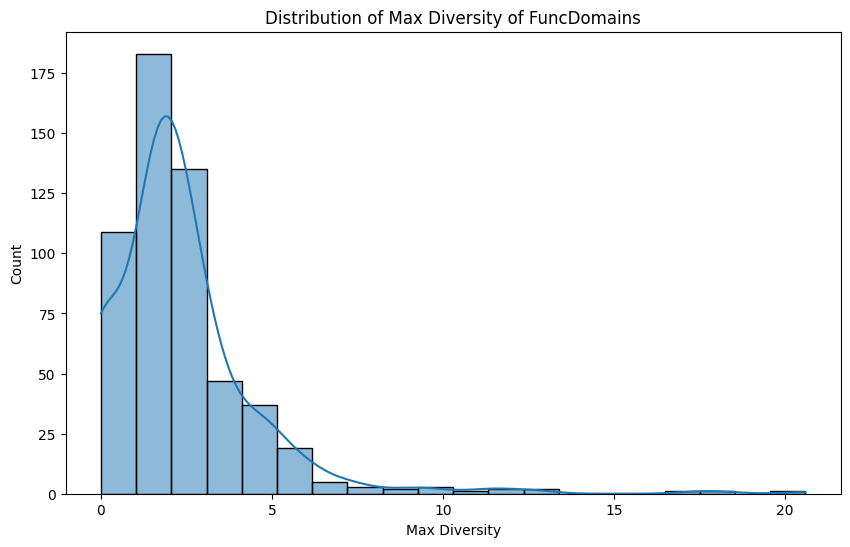

In [ ]:
# plot diversity distribution of all FuncDomains
pfam_diversity = pd.read_csv(DATASET_DIR + 'pfam_diversity.csv')

plt.figure(figsize=(10, 6))
sns.histplot(pfam_diversity['max_diversity'], bins=20, kde=True)
plt.xlabel('Max Diversity')
plt.ylabel('Count')
plt.title('Distribution of Max Diversity of FuncDomains')
plt.show()

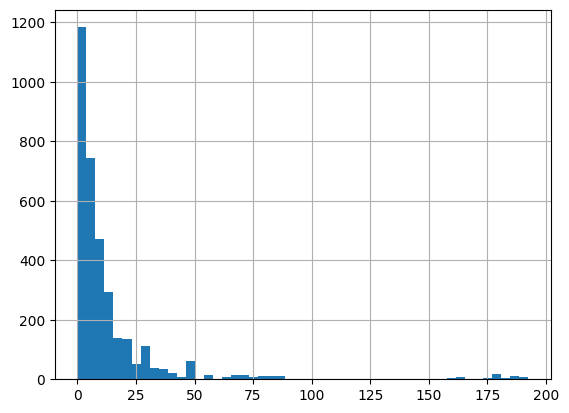

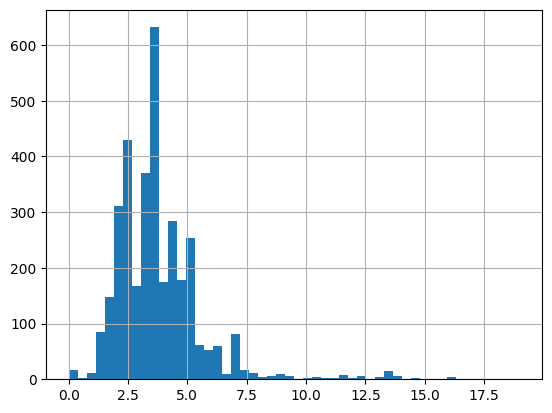

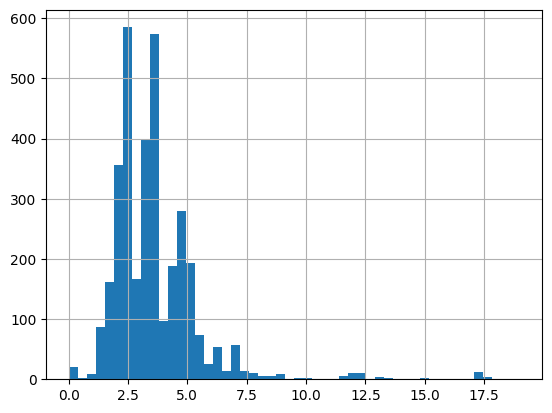

In [ ]:
# for each genome, plot the diversity of its FuncDomains (sum, mean, median)

def get_genome_func_domains(gds):
    if os.path.exists(DATASET_DIR + 'genome_func_domains.csv'):
        return pd.read_csv(DATASET_DIR + 'genome_func_domains.csv')
    query = '''
        MATCH (n:Genome)-[:HasReg]->(:HmmFuncDomain)<-[:HasMember]-(m:FuncDomainSet)
        RETURN n.accession as gb_acc, collect(distinct m.accession) as pfam_accs
    '''
    df = gds.run_cypher(query)
    df.to_csv(DATASET_DIR + 'genome_func_domains.csv', index=False)
    return df

genome_func_domains = get_genome_func_domains(None)

genome_pfam_max_diversity = collections.defaultdict(list)
genome_pfam_max_distance = collections.defaultdict(list)

for _, row in genome_func_domains.iterrows():
    for pfam_acc in ast.literal_eval(row['pfam_accs']):
        if pfam_acc in pfam_diversity['pfam_acc'].tolist():
            genome_pfam_max_diversity[row['gb_acc']].append(pfam_diversity.loc[pfam_diversity['pfam_acc'] == pfam_acc, 'max_diversity'].values[0])
            genome_pfam_max_distance[row['gb_acc']].append(pfam_diversity.loc[pfam_diversity['pfam_acc'] == pfam_acc, 'max_taxon_distance'].values[0])

rows = []
for gb_acc, diversities in genome_pfam_max_diversity.items():
    rows.append((gb_acc, np.sum(diversities), np.mean(diversities), np.median(diversities)))

for i, (gb_acc, distances) in enumerate(genome_pfam_max_distance.items()):
    rows[i] = rows[i] + (np.sum(distances), np.mean(distances), np.median(distances))

columns = ['gb_acc', 'sum_diversity', 'mean_diversity', 'median_diversity', 'sum_distance', 'mean_distance', 'median_distance']

genome_diversity = pd.DataFrame(rows, columns=columns)
genome_diversity.to_csv(DATASET_DIR + 'genome_diversity.csv', index=False)

genome_diversity['sum_diversity'].hist(bins=50)
plt.show()

genome_diversity['mean_diversity'].hist(bins=50)
plt.show()

genome_diversity['median_diversity'].hist(bins=50)
plt.show()

In [ ]:
# print top 10 FuncDomains with highest diversity
print(pfam_diversity.nlargest(10, 'max_diversity'))
print(pfam_diversity.nlargest(10, 'max_taxon_distance'))
print(pfam_diversity.nlargest(10, 'num_taxons'))


In [ ]:
# for each genome, get 
# { genbank_acc : OrderedDict{ pfam_acc: { b, e, hmmstart, hmmend} } }

def get_genome_pfam_hmm_coords(gds):
    if os.path.exists(DATASET_DIR + 'pfam_positions.csv'):
        return pd.read_csv(DATASET_DIR + 'pfam_positions.csv')
    query = '''
        MATCH (n:Genome)-[:HasReg]->(m:HmmFuncDomain)<-[:HasMember]-(k:FuncDomainSet)
        RETURN n.accession as gb_acc, k.accession as pfam_acc, m.b as b, m.e as e, m.hmmstart as hmmstart, m.hmmend as hmmend
        ORDER BY n.accession, m.b
    '''
    df = gds.run_cypher(query)
    return df

def get_pfam_positions(gds):
    if os.path.exists(DATASET_DIR + 'pfam_positions.csv'):
        return pd.read_csv(DATASET_DIR + 'pfam_positions.csv')

    genome_pfam_hmm_coords = get_genome_pfam_hmm_coords(gds)
    unique_gb_acc = genome_pfam_hmm_coords['gb_acc'].unique()
    genome_pfam_hmm_coords_dict = {}
    rows = []
    for gb_acc in unique_gb_acc:
        genome_pfam_hmm_coords_dict[gb_acc] = collections.OrderedDict()
        for _, row in genome_pfam_hmm_coords.loc[genome_pfam_hmm_coords['gb_acc'] == gb_acc].iterrows():
            genome_pfam_hmm_coords_dict[gb_acc][row['pfam_acc']] = {
                'b': row['b'],
                'e': row['e'],
                'hmmstart': row['hmmstart'],
                'hmmend': row['hmmend']
            }
            gb_record = get_gb_record(gb_acc)
            total_length = len(gb_record.seq) 
            domain_mid_point = (row['b'] + row['e']) / 2
            domain_center = domain_mid_point / total_length
            domain_length = row['e'] - row['b']
            rows.append((
                row['pfam_acc'],
                gb_acc,
                domain_center,
                domain_length,
                total_length,
            ))

    df = pd.DataFrame(rows, columns=['pfam_acc', 'gb_acc', 'domain_center', 'domain_length', 'total_length'])
    df.to_csv(DATASET_DIR + 'pfam_positions.csv', index=False)
    return df

genome_pfam_hmm_coords_df = get_pfam_positions(None)

In [ ]:
def add_top_k_rank_col(df, k=10):
    df['topPhylum'] = None
    top_k = df['phylum'].value_counts().index[:k]
    df['topPhylum'] = df['phylum']
    df.loc[(~df['phylum'].isin(top_k)), 'topPhylum'] = 'Other'
    return df

nodes = pd.read_csv(DATASET_DIR + 'nodes.csv')
genomes = nodes.loc[nodes['nodeLabels'] == 'Genome', ['accession', 'phylum']]
genomes = add_top_k_rank_col(genomes)


pfam_diversity = pd.read_csv(DATASET_DIR + 'pfam_diversity.csv')
merged = genome_pfam_hmm_coords_df.merge(pfam_diversity, how='inner', left_on='pfam_acc', right_on='pfam_acc')
merged = merged.merge(genomes, how='inner', left_on='gb_acc', right_on='accession')
merged = merged.drop(columns=['accession'])

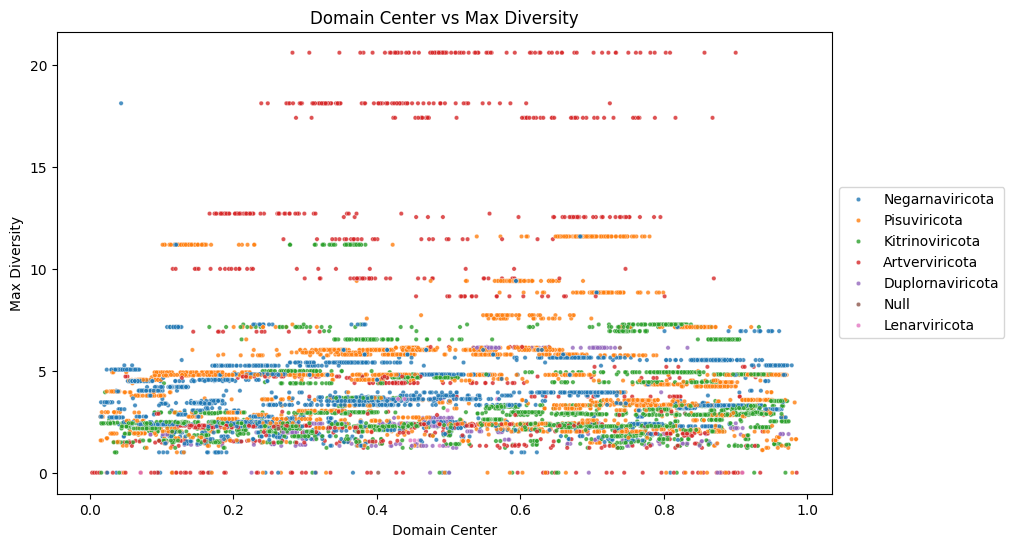

In [ ]:
# make scatter plot of pfams, with x-axis as domain center and y-axis as max_diversity

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='domain_center',
    y='max_diversity',
    data=merged,
    hue='topPhylum',
    palette='tab10',
    alpha=0.8,
    s=10
)
plt.xlabel('Domain Center')
plt.ylabel('Max Diversity')
plt.title('Domain Center vs Max Diversity')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


<Figure size 1000x600 with 0 Axes>

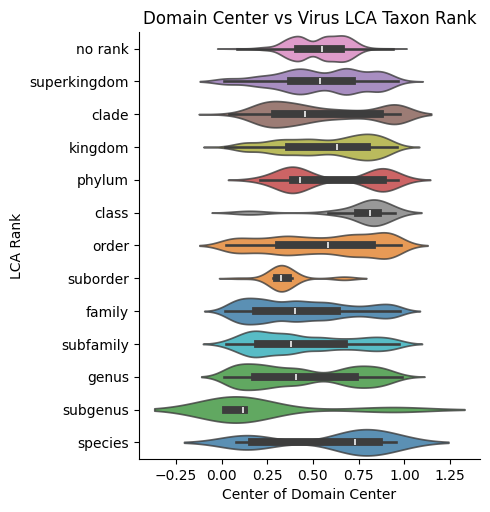

<Figure size 1000x1000 with 0 Axes>

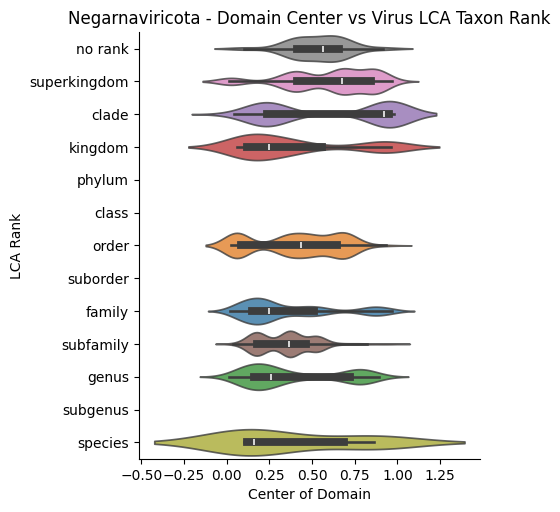

<Figure size 1000x1000 with 0 Axes>

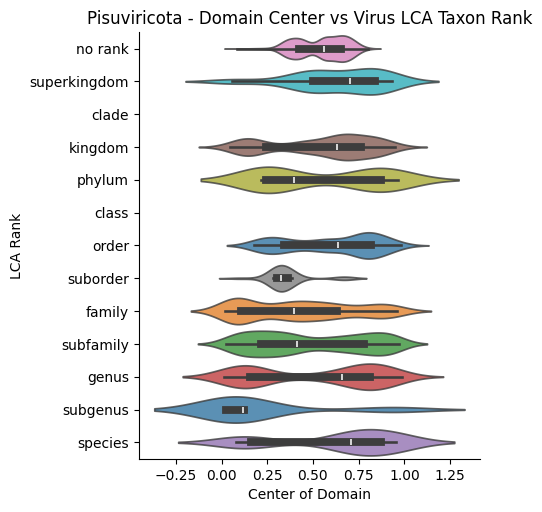

<Figure size 1000x1000 with 0 Axes>

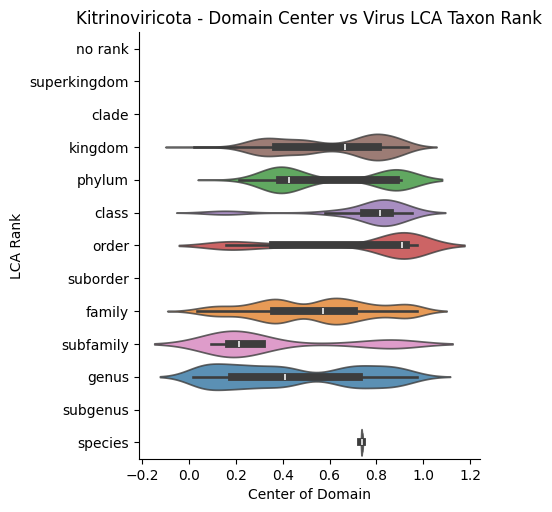

<Figure size 1000x1000 with 0 Axes>

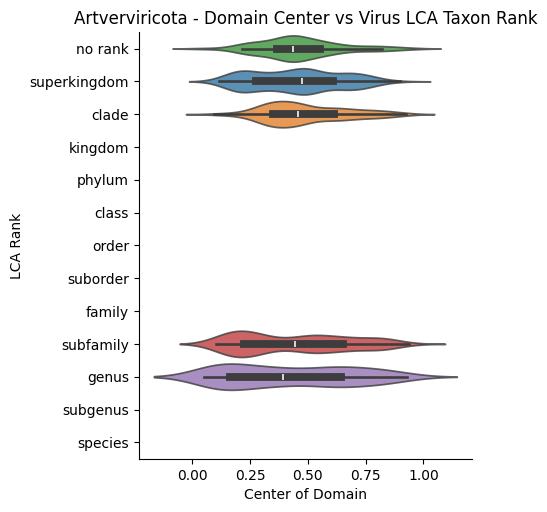

<Figure size 1000x1000 with 0 Axes>

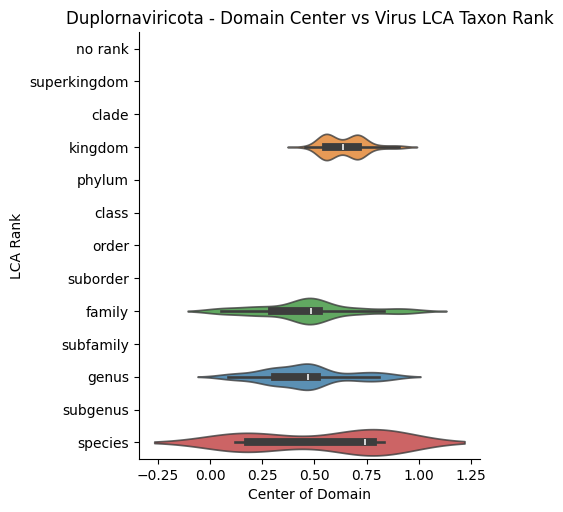

<Figure size 1000x1000 with 0 Axes>

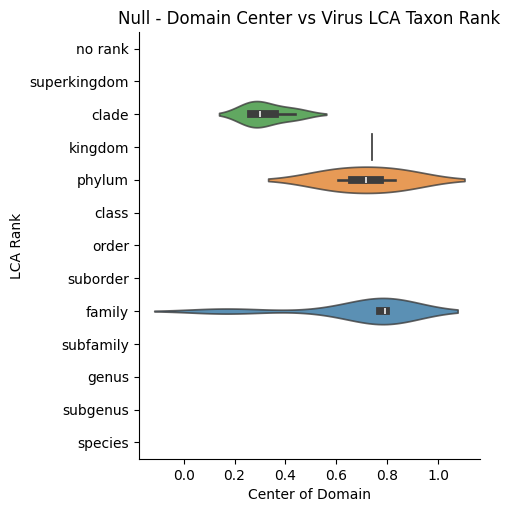

<Figure size 1000x1000 with 0 Axes>

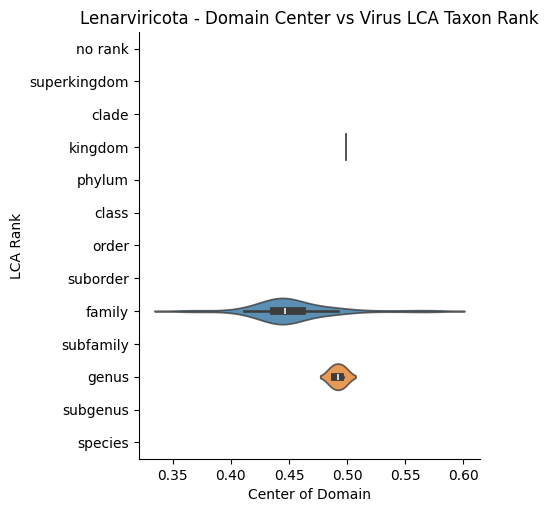

In [ ]:
rank_ordering =[
    'no rank',
    'superkingdom',
    'clade',
    'kingdom',
    'phylum',
    'class',
    'order',
    'suborder',
    'family',
    'subfamily',
    'genus',
    'subgenus',
    'species',
]

plt.figure(figsize=(10, 6))
g = sns.catplot(
    data=merged,
    x='domain_center',
    y='lcaRank',
    hue='lcaRank',
    palette='tab10',
    alpha=0.8,
    # s=10,
    order=rank_ordering,
    kind="violin", # 'strip', 'swarm', 'box', 'boxen', 'violin', 'bar', 'count', and 'point'.
    legend=False,
)
plt.xlabel('Center of Domain Center')
plt.ylabel('LCA Rank')
plt.title('Domain Center vs Virus LCA Taxon Rank')
plt.show()


for phylum in merged['topPhylum'].unique():
    plt.figure(figsize=(10, 10))
    g = sns.catplot(
        data=merged[merged['topPhylum'] == phylum],
        x='domain_center',
        y='lcaRank',
        hue='lcaRank',
        order=rank_ordering,
        palette='tab10',
        alpha=0.8,
        kind="violin",
        legend=False,
    )
    plt.xlabel('Center of Domain')
    plt.ylabel('LCA Rank')
    plt.title(f'{phylum} - Domain Center vs Virus LCA Taxon Rank')
    plt.show()

<Figure size 1000x600 with 0 Axes>

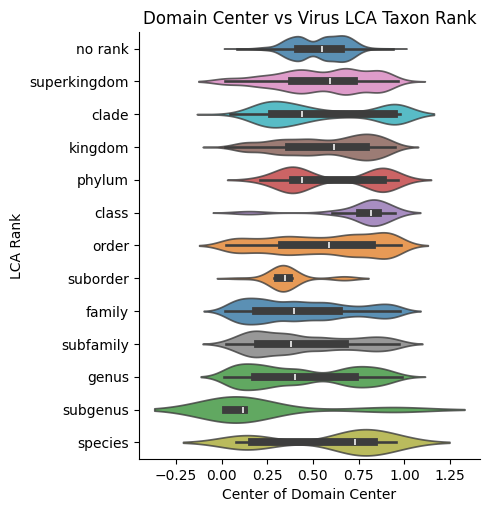

<Figure size 1000x1000 with 0 Axes>

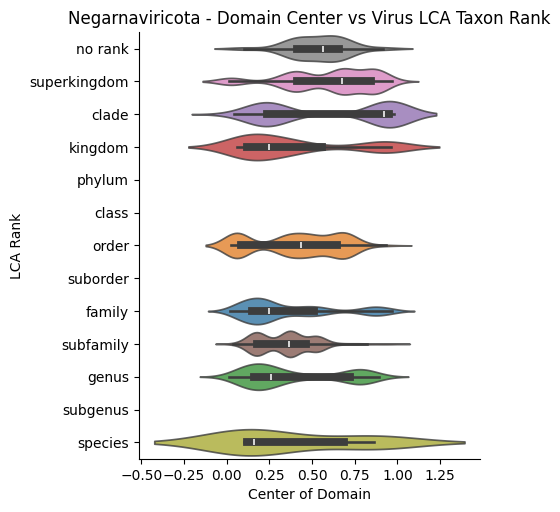

<Figure size 1000x1000 with 0 Axes>

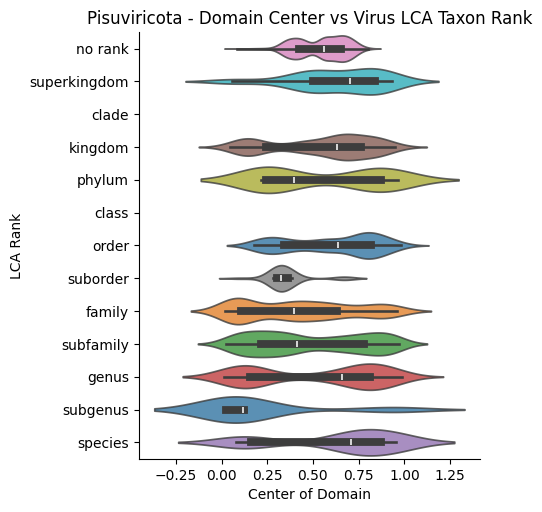

<Figure size 1000x1000 with 0 Axes>

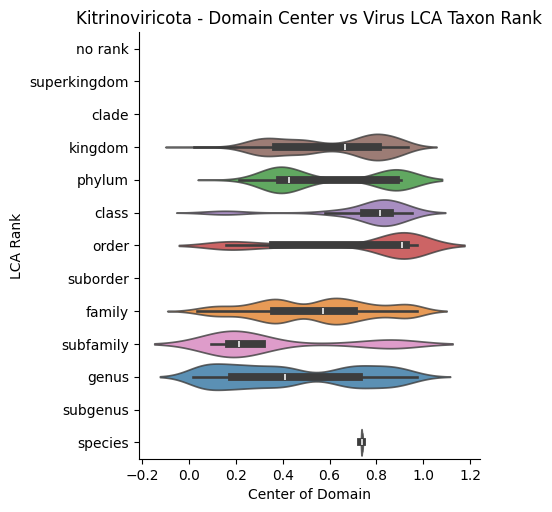

<Figure size 1000x1000 with 0 Axes>

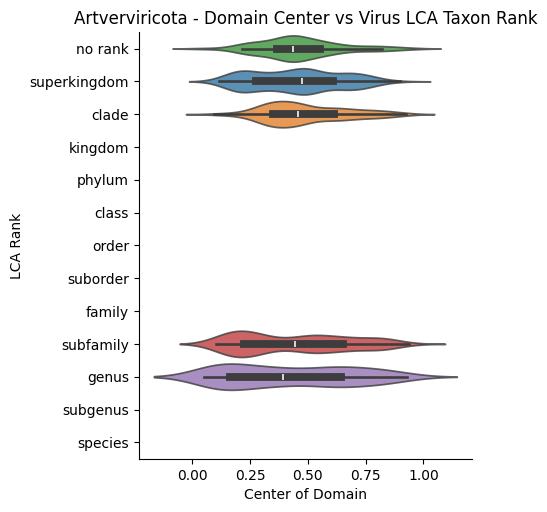

<Figure size 1000x1000 with 0 Axes>

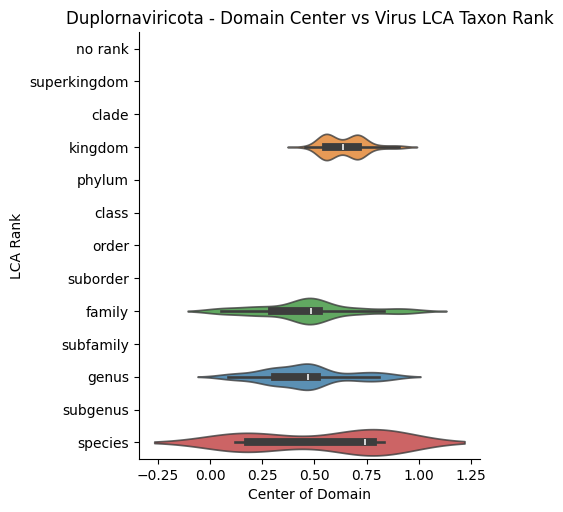

<Figure size 1000x1000 with 0 Axes>

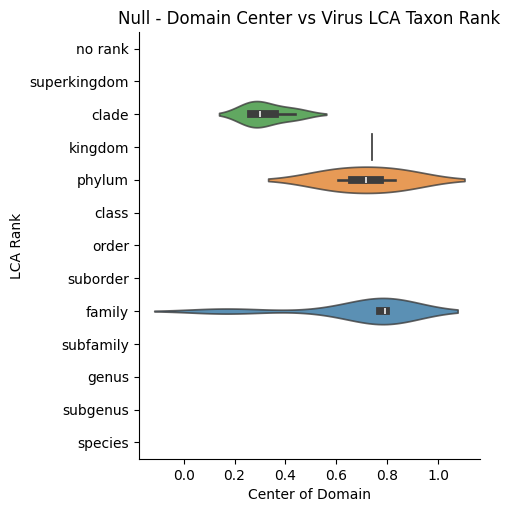

<Figure size 1000x1000 with 0 Axes>

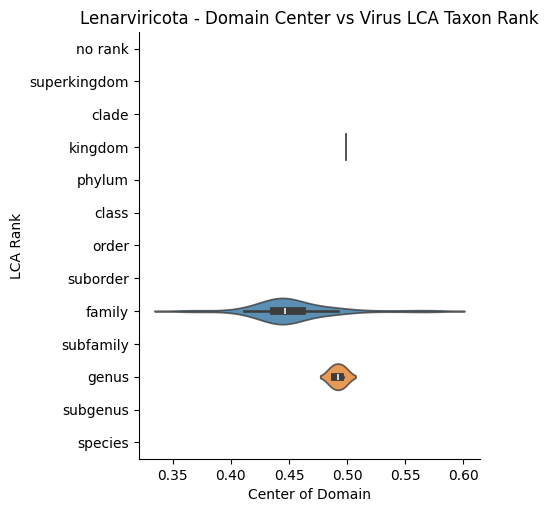

In [ ]:
complete_genomes_merged = merged.loc[merged['gb_acc'].isin(genbank_complete_genomes)]

rank_ordering =[
    'no rank',
    'superkingdom',
    'clade',
    'kingdom',
    'phylum',
    'class',
    'order',
    'suborder',
    'family',
    'subfamily',
    'genus',
    'subgenus',
    'species',
]

plt.figure(figsize=(10, 6))
g = sns.catplot(
    data=complete_genomes_merged,
    x='domain_center',
    y='lcaRank',
    hue='lcaRank',
    palette='tab10',
    alpha=0.8,
    # s=10,
    order=rank_ordering,
    kind="violin", # 'strip', 'swarm', 'box', 'boxen', 'violin', 'bar', 'count', and 'point'.
    legend=False,
)
plt.xlabel('Center of Domain Center')
plt.ylabel('LCA Rank')
plt.title('Domain Center vs Virus LCA Taxon Rank')
plt.show()


for phylum in merged['topPhylum'].unique():
    plt.figure(figsize=(10, 10))
    g = sns.catplot(
        data=merged[merged['topPhylum'] == phylum],
        x='domain_center',
        y='lcaRank',
        hue='lcaRank',
        order=rank_ordering,
        palette='tab10',
        alpha=0.8,
        kind="violin",
        legend=False,
    )
    plt.xlabel('Center of Domain')
    plt.ylabel('LCA Rank')
    plt.title(f'{phylum} - Domain Center vs Virus LCA Taxon Rank')
    plt.show()

## Inverted Index

In [38]:
def get_gb_from_pfam_acc(gds, pfam_acc):
    query = f"""
        MATCH (x:HitFamily)-[]-(y:Hit)-[]-(z:Fasta) 
        WHERE x.accession = '{pfam_acc}'
        WITH collect(DISTINCT z.accession) as gb_acc
        return gb_acc
    """
    gb_acc = gds.run_cypher(query)
    return gb_acc['gb_acc'].values[0]

def get_pfams_from_gb_acc(gds, gb_acc):
    query = f"""
        MATCH (x:Fasta)-[]-(y:Hit)-[]-(z:HitFamily)
        WHERE x.accession = '{gb_acc}'
        WITH collect(DISTINCT z.accession) as pfam_acc
        return pfam_acc
    """
    pfam_acc = gds.run_cypher(query)
    return pfam_acc['pfam_acc'].values[0]

In [16]:
# pfam -> genome -> palm -> sotu -> sra -> tissue/host

genbank_taxids = get_genbank_taxids(genbank_acc)
palm_gb = get_palm_gb()
palm_sotu = get_palm_sotu(palm_gb)
palm_sra_keep = get_sotu_sra(palm_sotu)
biosample_tissue = get_sra_tissue(palm_sra_keep)
sra_stat = get_sra_stat(palm_sra_keep)


# get all sotus associated to pfam domain "PF14314"
target_gbs = get_gb_from_pfam_acc(pg_client, 'PF14314')
target_taxids = genbank_taxids.loc[genbank_taxids['accession'].isin(target_gbs), 'tax_id']
target_taxids = target_taxids.unique()
target_palm_ids = palm_gb.loc[palm_gb['tax_id'].isin(target_taxids), 'palm_id']
target_palm_ids = target_palm_ids.unique()
target_sotus = palm_sotu.loc[palm_sotu['palm_id'].isin(target_palm_ids), 'sotu']
target_sotus = target_sotus.unique() 
target_sras = palm_sra_keep.loc[palm_sra_keep['sotu'].isin(target_sotus), 'run_id']

target_stats = sra_stat.loc[sra_stat['run'].isin(target_sras)]
target_tissues = biosample_tissue.loc[biosample_tissue['run'].isin(target_sras)]


print(target_stats['taxid'].nunique())
print(target_tissues['bto_id'].nunique())



(1565368, 5)
386438
168641
(43558, 6)
(29938, 5)


In [40]:
# tissue/host -> sra -> sotu -> palm -> taxids -> genomes -> pfam

primate_tax_id = 9443
tissue_id = 'BTO_0002881'

target_stats = sra_stat.loc[sra_stat['taxid'] == primate_tax_id]
target_tissues = biosample_tissue.loc[biosample_tissue['bto_id'] == tissue_id]

target_sras_1 = target_tissues['run'].unique()
target_sras_2 = target_stats['run'].unique()

print(len(target_sras_1))
print(len(target_sras_2))

target_sras = set(target_sras_1).intersection(target_sras_2)

print(len(target_sras))

target_sotus = palm_sra_keep.loc[palm_sra_keep['run_id'].isin(target_sras), 'sotu']
target_sotus = target_sotus.unique()
print(len(target_sotus))

target_palm_ids = palm_sotu.loc[palm_sotu['sotu'].isin(target_sotus), 'palm_id']
target_palm_ids = target_palm_ids.unique()
target_taxids = palm_gb.loc[palm_gb['palm_id'].isin(target_palm_ids), 'tax_id']
target_taxids = target_taxids.unique()
print(len(target_taxids))

target_gbs = genbank_taxids.loc[genbank_taxids['tax_id'].isin(target_taxids), 'accession']
target_gbs = target_gbs.unique()
print(len(target_gbs))

target_pfams = []
for gb in target_gbs:
    pfams = get_pfams_from_gb_acc(pg_client, gb)
    target_pfams.extend(pfams)

print(len(target_pfams))
target_pfams = set(target_pfams)
print(len(target_pfams))

22
17075
3
3
7
11
493
101
